Loading Data

Using Beans Disease Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [ ]:
!unzip '/content/drive/MyDrive/beans.zip' -d '/content/bean'

Archive:  /content/drive/MyDrive/beans.zip
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.0.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.1.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.10.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.11.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.12.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.13.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.14.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.15.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.16.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.17.jpg  
  inflating: /content/bean/test/test/angular_leaf_spot/angular_leaf_spot_test.18.jpg  
  

In [ ]:
train_data_dir='/content/bean/train/train'
validation_data_dir='/content/bean/validation/validation'
test_data_dir='/content/bean/test/test'

In [ ]:
nb_train_samples=1035
nb_validation_samples=133

In [ ]:
img_width = 256
img_height = 256
batch_size=32

In [ ]:
class_names=['angular_leaf_spot','bean_rust','healthy']

In [ ]:
import os
import random

In [ ]:
img='/content/bean/test/test'

Visualizing some examples

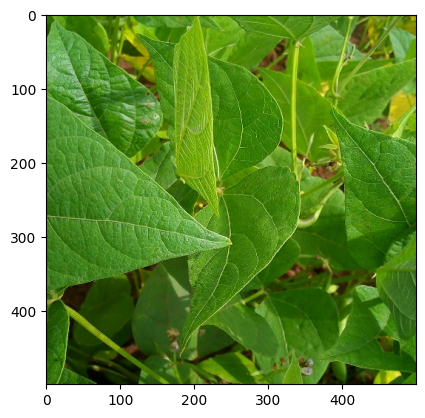

In [ ]:
import matplotlib.pyplot as plt

im=plt.imread('/content/bean/validation/validation/healthy/healthy_val.43.jpg')
plt.imshow(im)
plt.show()

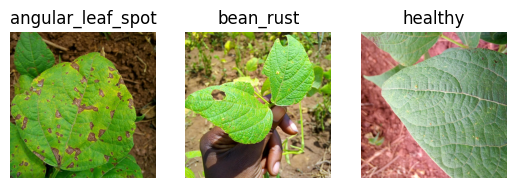

In [ ]:
images = []

# Loop through all class names and pick a random image for each class
for class_name in class_names:
    image_files = os.listdir(os.path.join(img, class_name))
    image_file = random.choice(image_files)
    images.append(os.path.join(img, class_name, image_file))

# Loop through all the images and display them in the subplot
fig, ax = plt.subplots(1,3)
for i in range(3):
    img = plt.imread(images[i])
    ax[i].imshow(img)
    ax[i].set_title(class_names[i])
    ax[i].axis('off')

Splitting data into train and validation with Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1034 images belonging to 3 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 133 images belonging to 3 classes.


Import required libraries for model building

In [ ]:
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,MaxPooling2D

#Xception model

Xception is a convolutional neural network. Xception is the pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals etc… The network has an image input size of 299X299.

Architecture Xception, which stands for “Extreme Inception”. The Xception architecture has 36 convolutional layers forming the feature extraction base of the network.

The data first goes through the entry flow, then through the middle flow which is repeated eight times, and finally through the exit flow. Note that all Convolution and Separable Convolution layers are followed by batch normalization (not included in the diagram). All Separable Convolution layers use a depth multiplier of 1 (no depth expansion).

Model Building

In [ ]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=3)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
model = keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,386,795
Trainable params: 525,315
Non-trainable params: 20,861,480
____________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Training the model

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=25,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/25
32/32 [==============================] - 388s 12s/step - loss: 0.7582 - accuracy: 0.6766 - val_loss: 0.5599 - val_accuracy: 0.7578
Epoch 2/25
32/32 [==============================] - 373s 12s/step - loss: 0.4959 - accuracy: 0.8064 - val_loss: 0.3559 - val_accuracy: 0.8906
Epoch 3/25
32/32 [==============================] - 411s 13s/step - loss: 0.3974 - accuracy: 0.8473 - val_loss: 0.3404 - val_accuracy: 0.8828
Epoch 4/25
32/32 [==============================] - 372s 12s/step - loss: 0.3691 - accuracy: 0.8543 - val_loss: 0.3296 - val_accuracy: 0.8750
Epoch 5/25
32/32 [==============================] - 411s 13s/step - loss: 0.3352 - accuracy: 0.8752 - val_loss: 0.3636 - val_accuracy: 0.8750
Epoch 6/25
32/32 [==============================] - 410s 13s/step - loss: 0.3553 - accuracy: 0.8533 - val_loss: 0.5471 - val_accuracy: 0.7969
Epoch 7/25
32/32 [==============================] - 372s 12s/step - loss: 0.3786 - accuracy: 0.8513 - val_loss: 0.3236 - val_accuracy: 0.8984
Epoch 

Generating Test Set

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 128 images belonging to 3 classes.


Evaluate model performance on test set

In [ ]:
scores = model.evaluate(test_generator)

4/4 [==============================] - 42s 10s/step - loss: 0.3112 - accuracy: 0.8359


In [ ]:
scores

[0.3111681640148163, 0.8359375]

Visualizing the performance of the model based on accuracy

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

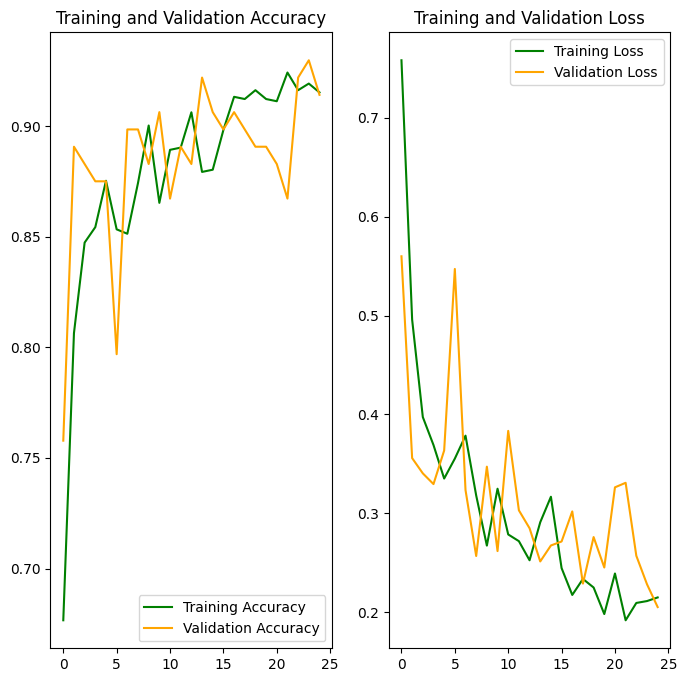

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, color='green', label='Training Accuracy')
plt.plot(range(25), val_acc, color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, color='green', label='Training Loss')
plt.plot(range(25), val_loss,color='orange', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Making predictions and visualizing some of them

4/4 [==============================] - 43s 10s/step


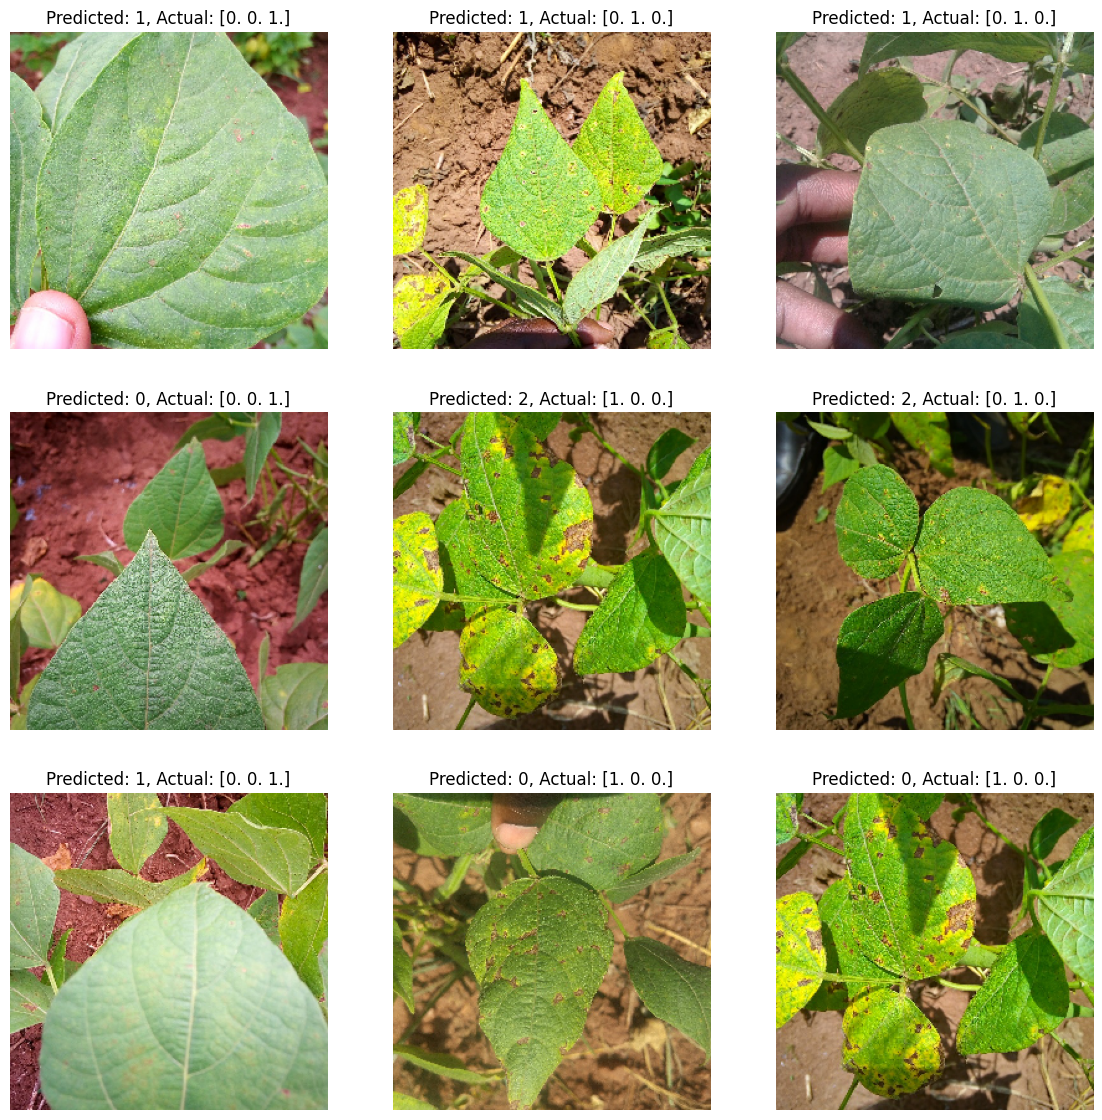

In [ ]:
predictions = model.predict(test_generator)

num_images_to_show = 9
plt.figure(figsize=(14, 14))
for i in range(num_images_to_show):
    image, label = test_generator.next()
    predicted_label = predictions[i].argmax()

    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(image[0])
    ax.set_title(f"Predicted: {predicted_label}, Actual: {label[0]}")
    ax.axis("off")
plt.show()